In this notebook, we show how to use functions defined in loader.py, neural_network.py, plot.py, train.py and loss.py to study first round of french 2017 presidentiel election.

This notebook was used to obtain the different figures presented in our report

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

sns.set()

C:\Users\Antonin\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from loader import *
from neural_network import *
from plot import *
from train import *
from loss import *

# LOAD FILES AND PREPARE TRAIN AND TEST SET

In [3]:
# LOAD CSV FILES
insee_dataset = pd.read_csv('../data/data_INSEE_clean.csv', sep=';', dtype = {'code': str})
first_round_result = pd.read_csv("../data/clean_f_round_elect_results.csv", sep = ";", \
                                     dtype = {'Code Insee': str}).drop(columns=["Inscrits", "Nuls", "Votants"])

dataset = insee_dataset.merge(first_round_result, how='inner', left_on='code', right_on='Code Insee') \
                             .drop(columns=["Code Insee"])


candidates_list = ['HAMON', 'DUPONT-AIGNAN', 'LASSALLE', 'ARTHAUD', 'POUTOU', \
                   'ASSELINEAU', 'MACRON', 'MÉLENCHON', 'FILLON', 'CHEMINADE', 'LE PEN']

nb_candidates = len(candidates_list)

In [4]:
# DIFFERENT SETS OF FEATURES 
sparse_features = ['density_pop', 'Indice_vieillissement', 'ratio_etude_sup','mean_familiy_size',\
                   'ratio_etude_sup', 'hlm', 'res_second', 'ta_homme', 'part_agri_y', 'part_cadre']

all_features = list(set(insee_dataset.columns) - set(["code", "commune", "pop", "type_agglo"]))

features_wo_equipmements = list(set(all_features)-set(['hypermarché', 'pôle emploi','banques', 'poste', 'epicerie', \
                'boulangerie', 'boucherie', 'maternelle', 'élémentaire', 'collège', 'urgences', \
                'lycee', 'dentiste', 'medecin','infirmier', 'creche', 'kine', 'pharmacie', 'epahd']))

In [5]:
# CHOOSE HERE THE SET FEATURES YOU WANT TO KEEP
features_to_keep = all_features
nb_features = len(features_to_keep)

print("number of initial features", nb_features)

# CHOOSE DIFFERENT VARIABLES
batch_size = 36 # FOR PYTORCH NEURAL NETWORK TRAINING
min_habs = 500 # WILL DROP A CITY IF IT HAS LESS THAN MIN_HABS INHABITANTS
test_size = 0.5 # RATIO TEST / TRAIN SIZE
apply_PCA, n_components = False, 20 # TO APPLY PCA AND KEEP ONLY n_components
if apply_PCA : nb_features = n_components
    
    

number of initial features 67


In [6]:
x_train, x_test, y_train, y_test, train_loader, commune_index_train, commune_index_test = \
    load_data(dataset, features_to_keep, batch_size, min_habs, test_size, \
              apply_PCA=apply_PCA, n_components_PCA=n_components)

df_y_train = pd.DataFrame(y_train, columns=candidates_list)
df_y_test = pd.DataFrame(y_test, columns=candidates_list)

In [7]:
print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)


x_train shape (7663, 67)
y_train shape (7663, 11)
x_test shape (7663, 67)
y_test shape (7663, 11)


# COMPARE NEURAL NETWORK WITHOUT AND WITHOUT SOFTMAX

In [21]:
model_no_softmax =  NN2Layers_no_softmax(nb_features, 200, nb_candidates)
model_with_softmax = NN2Layers_with_softmax(nb_features, 200, nb_candidates)
model_1Layer = NN1Layer(nb_features, nb_candidates)

In [22]:
optimizer_no_softmax = torch.optim.Adam(model_no_softmax.parameters())
optimizer_with_softmax = torch.optim.Adam(model_with_softmax.parameters())
optimizer_1Layer = torch.optim.Adam(model_1Layer.parameters())

In [23]:
train_neurals_networks(40, train_loader, \
                       [cross_entropy_loss, cross_entropy_loss, cross_entropy_loss], \
                       [model_no_softmax, model_with_softmax, model_1Layer], \
                       [optimizer_no_softmax, optimizer_with_softmax, optimizer_1Layer], print_epochs=10)

epoch n° 0
  model n° 0 - loss : 2.039978886993838
  model n° 1 - loss : 1.847832568374598
  model n° 2 - loss : 2.381980034107334
----
epoch n° 10
  model n° 0 - loss : 1.8076812275138818
  model n° 1 - loss : 1.8008338358480607
  model n° 2 - loss : 1.824298231254721
----
epoch n° 20
  model n° 0 - loss : 1.8027688723774584
  model n° 1 - loss : 1.799525004597337
  model n° 2 - loss : 1.8074539278594541
----
epoch n° 30
  model n° 0 - loss : 1.8014181516539882
  model n° 1 - loss : 1.7982773562552223
  model n° 2 - loss : 1.8055782368485356
----


In [24]:
list_of_pred_df = pred_model(x_train, x_test, [model_no_softmax, model_with_softmax, model_1Layer])

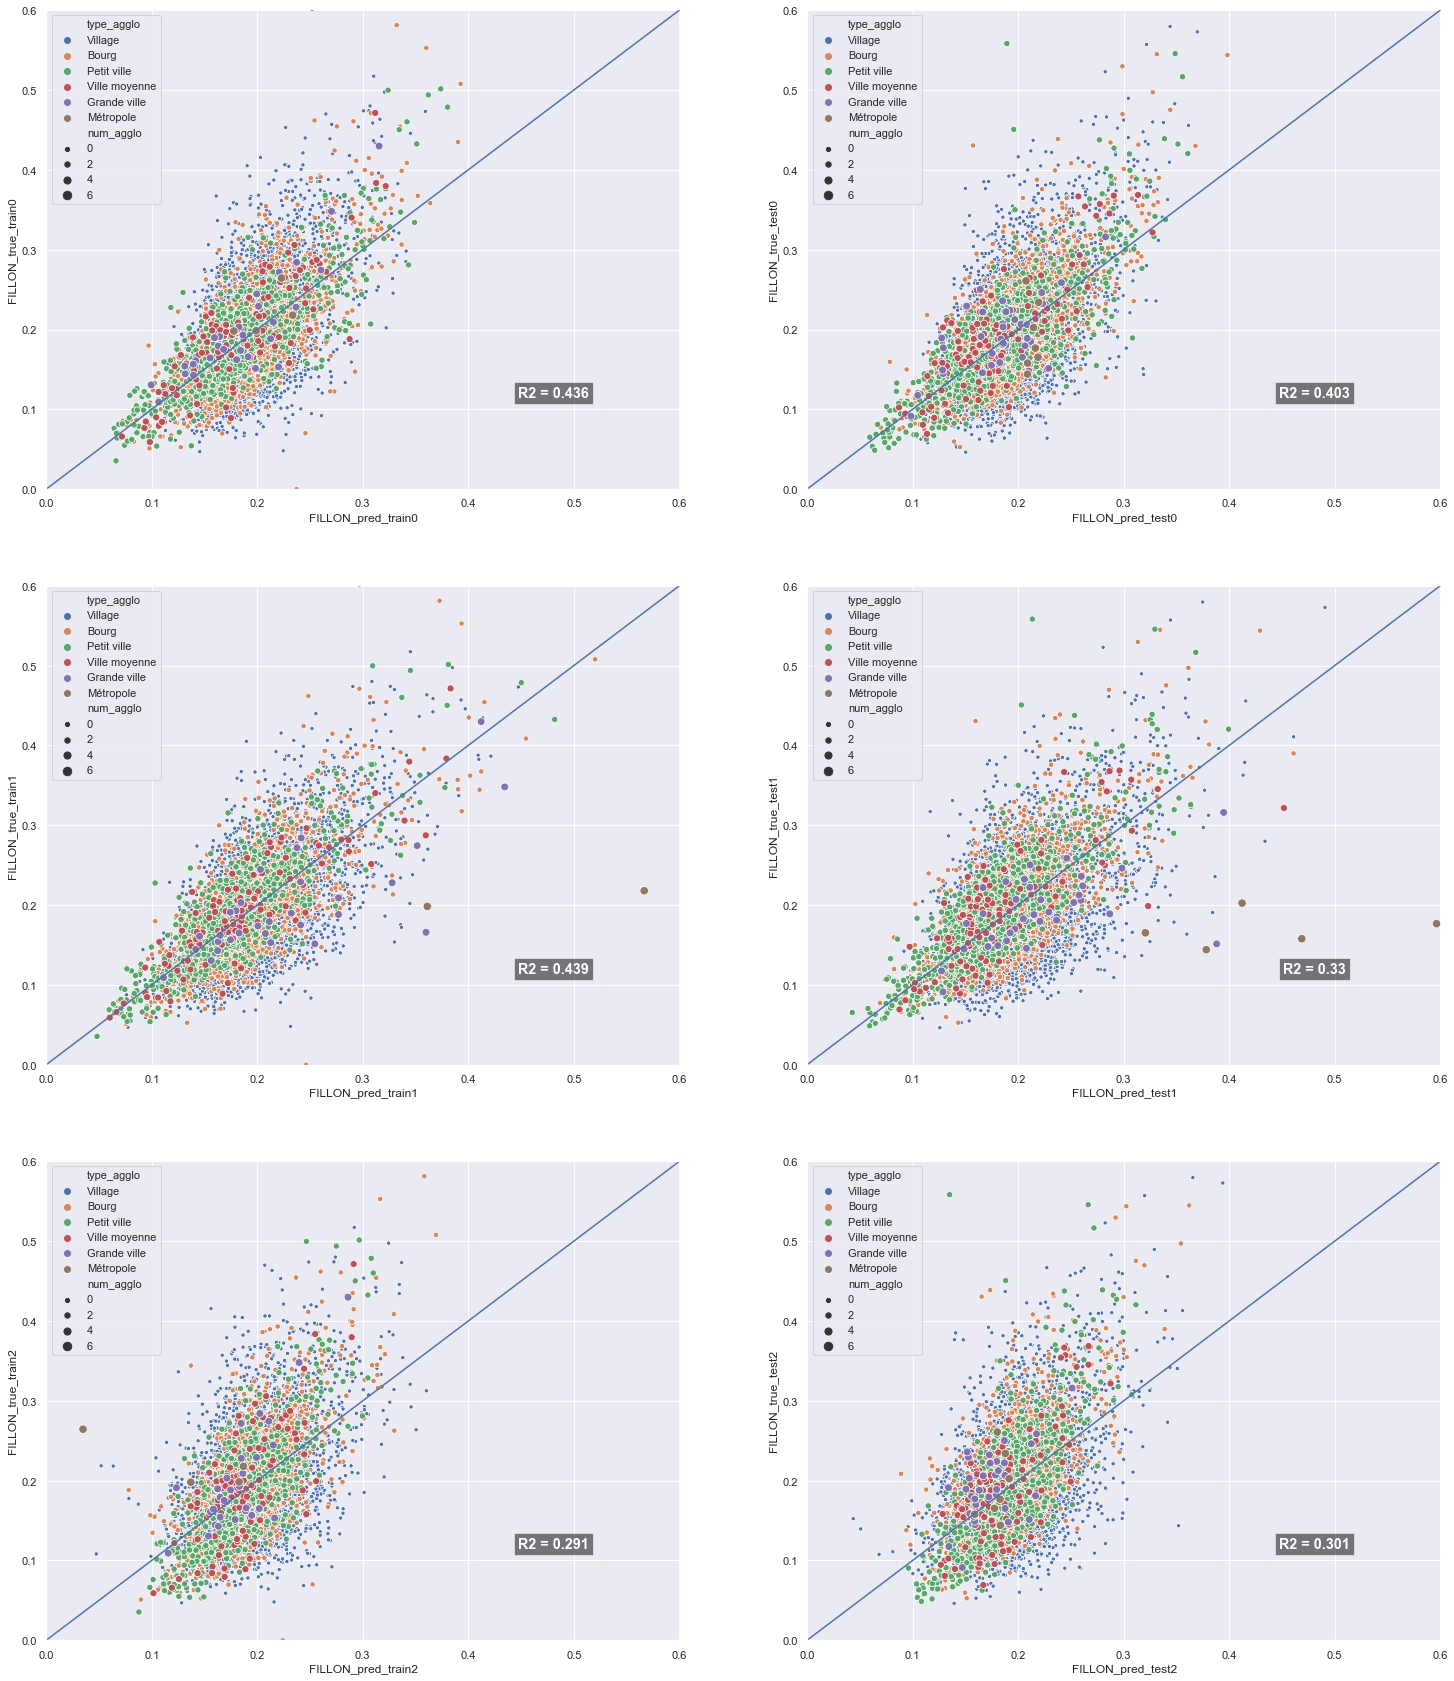

In [26]:
regression_plot(y_train, y_test, list_of_pred_df, "FILLON", commune_index_train, commune_index_test)

In [28]:
compute_R2_df(list_of_pred_df[2][1],df_y_test)

R2 pour HAMON  :  0.11971943812023211
R2 pour DUPONT-AIGNAN  :  0.2019126092445308
R2 pour LASSALLE  :  0.14810192864215754
R2 pour ARTHAUD  :  0.12843990006025952
R2 pour POUTOU  :  0.08065698071634264
R2 pour ASSELINEAU  :  -0.0034846624651114766
R2 pour MACRON  :  0.3260079495928502
R2 pour MÉLENCHON  :  0.14877472844360495
R2 pour FILLON  :  0.3008223497335326
R2 pour CHEMINADE  :  -0.04124769778495785
R2 pour LE PEN  :  0.3966133269336768


[0.11971943812023211,
 0.2019126092445308,
 0.14810192864215754,
 0.12843990006025952,
 0.08065698071634264,
 -0.0034846624651114766,
 0.3260079495928502,
 0.14877472844360495,
 0.3008223497335326,
 -0.04124769778495785,
 0.3966133269336768]

# ONE VS REST APPROACH

### Idea : train 11 log_reg

In [32]:
# TRAIN 11 neurons in parallel (inside 11 different neural network models)
# Note that we do not output a probability distribution anymore. But we don't care because
# we just want to try to embed the candidats into vectors
list_of_logreg = [Log_reg_one_neuron(nb_features) for i in range(11)]
list_of_optims = [torch.optim.Adam(list_of_logreg[i].parameters()) for i in range(11)]
list_of_losses = [(lambda x : lambda y,target : cross_entropy_loss_1Neuron(y, target[:,x].view(-1,1)))(i)\
                   for i in range(11)]

In [33]:
train_neurals_networks(n_epochs=50, train_loader=train_loader, \
                       list_of_loss_function=list_of_losses, \
                       list_of_models=list_of_logreg,\
                       list_of_optim=list_of_optims,
                       print_epochs=10)

epoch n° 0
  model n° 0 - loss : 0.6717561038447099
  model n° 1 - loss : 0.6299784891482251
  model n° 2 - loss : 0.6227275078565302
  model n° 3 - loss : 0.7706513740647007
  model n° 4 - loss : 0.6171441667236632
  model n° 5 - loss : 0.6092662402721638
  model n° 6 - loss : 0.6463194061333025
  model n° 7 - loss : 0.6500756614644763
  model n° 8 - loss : 0.7328849751065035
  model n° 9 - loss : 0.7349852175220077
  model n° 10 - loss : 0.6693532576023693
----
epoch n° 10
  model n° 0 - loss : 0.25790075272181784
  model n° 1 - loss : 0.2569619757888463
  model n° 2 - loss : 0.17203386988438352
  model n° 3 - loss : 0.19605887404909716
  model n° 4 - loss : 0.1693105763392829
  model n° 5 - loss : 0.16205350774834412
  model n° 6 - loss : 0.518817232248369
  model n° 7 - loss : 0.4657516227641576
  model n° 8 - loss : 0.4865277781732765
  model n° 9 - loss : 0.17668613749490658
  model n° 10 - loss : 0.5628891570467345
----
epoch n° 20
  model n° 0 - loss : 0.21143920306868397
  mod

In [34]:
# COMPUTE THE PREDICTION FOR EACH CANDIDATES ON TEST SET 
y_pred_train = pd.DataFrame(columns=candidates_list)
y_pred_test = pd.DataFrame(columns=candidates_list)

with torch.no_grad():
    for i, cand in enumerate(candidates_list):
        y_pred_train[cand] = list_of_logreg[i](torch.from_numpy(x_train).float()).view(-1).numpy()
        y_pred_test[cand] = list_of_logreg[i](torch.from_numpy(x_test).float()).view(-1).numpy()

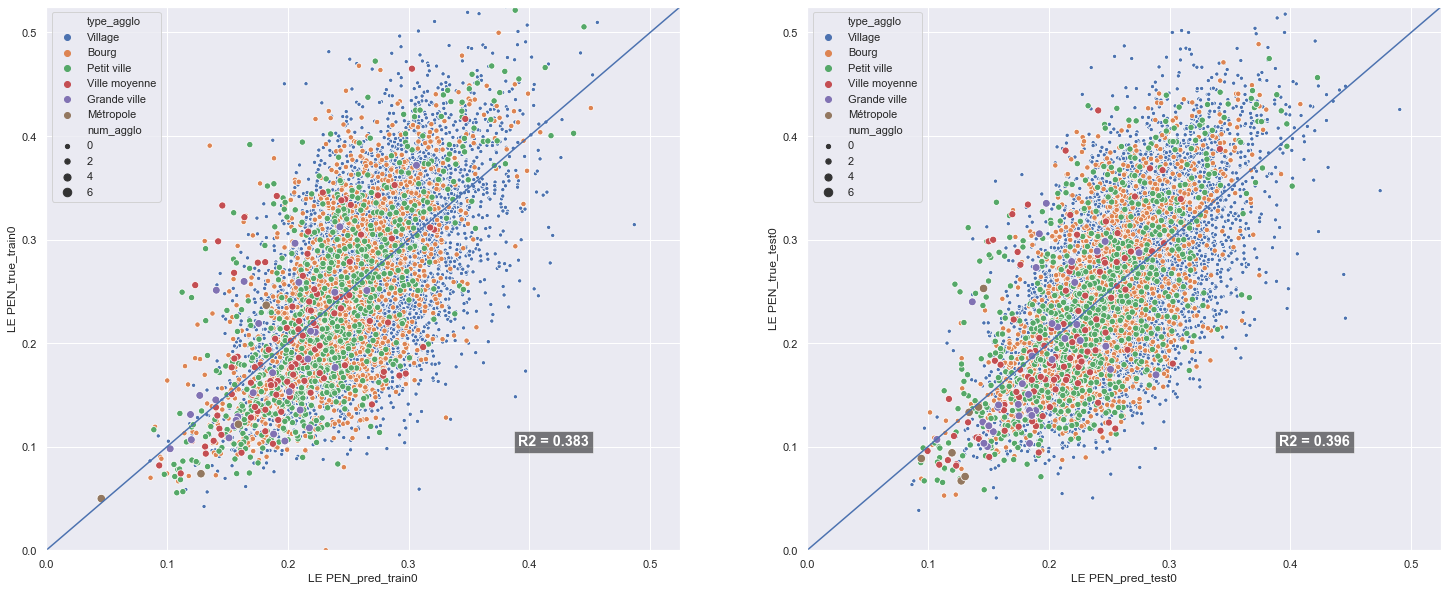

In [35]:
# CHECK IF WE HAVE LEARNED ANYTHING
regression_plot(y_train, y_test, [(y_pred_train, y_pred_test)], "LE PEN", commune_index_train, commune_index_test)

In [36]:
compute_R2_df(y_pred_test,df_y_test)

R2 pour HAMON  :  0.11368482994258011
R2 pour DUPONT-AIGNAN  :  0.19340658873033434
R2 pour LASSALLE  :  0.14619292638953785
R2 pour ARTHAUD  :  0.17095429817209762
R2 pour POUTOU  :  0.08345845294539245
R2 pour ASSELINEAU  :  0.03731273468138774
R2 pour MACRON  :  0.32760256541020993
R2 pour MÉLENCHON  :  0.14058936714785752
R2 pour FILLON  :  0.3092158935945992
R2 pour CHEMINADE  :  -2.180193363645165
R2 pour LE PEN  :  0.39558446803355896


[0.11368482994258011,
 0.19340658873033434,
 0.14619292638953785,
 0.17095429817209762,
 0.08345845294539245,
 0.03731273468138774,
 0.32760256541020993,
 0.14058936714785752,
 0.3092158935945992,
 -2.180193363645165,
 0.39558446803355896]

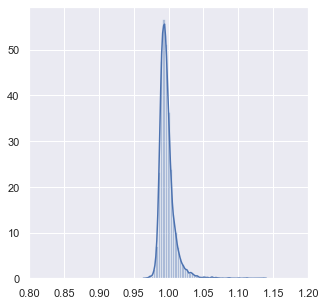

In [37]:
# CHECK THE DISTRUBTION OF OUTPUT VECTOR'S NORM
f, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.set_xlim(0.8, 1.2)
sns.distplot(y_pred_test.sum(axis=1))


### OneVsRest with 11 Gradient Boosting Classifier

In [12]:
x_train.shape

(7663, 67)

Train score :  0.39257654146656507
Train score :  0.4326528215411637
Train score :  0.5148831012659912
Train score :  0.3812618629549205
Train score :  0.31658326599520104
Train score :  0.2730914703220211
Train score :  0.5916783636165306
Train score :  0.4698954623129429
Train score :  0.5734155064901273
Train score :  0.21805774376193818
Train score :  0.6521829398837858


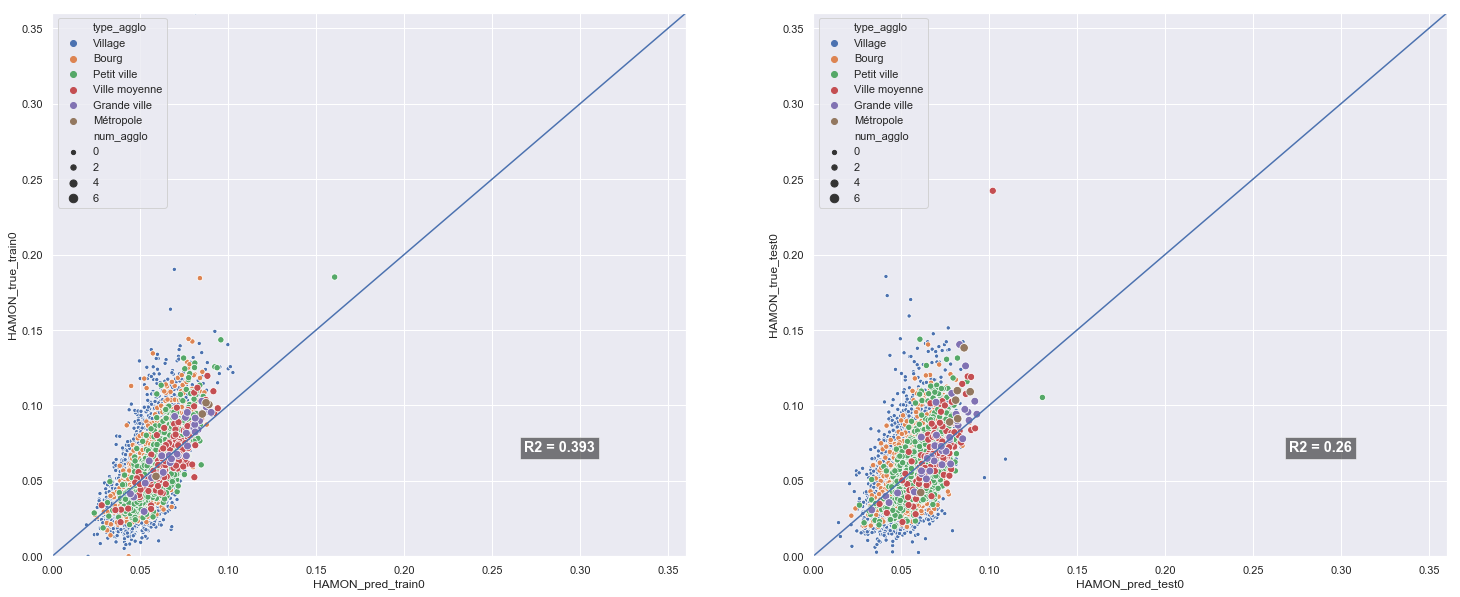

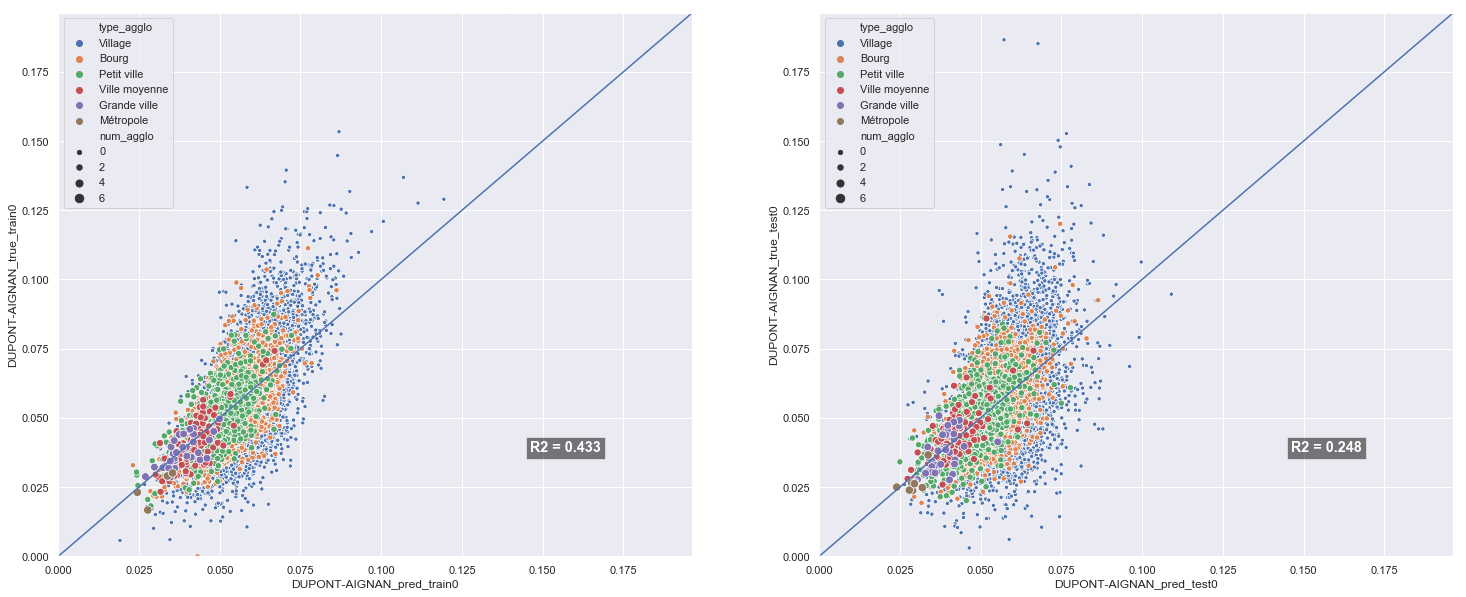

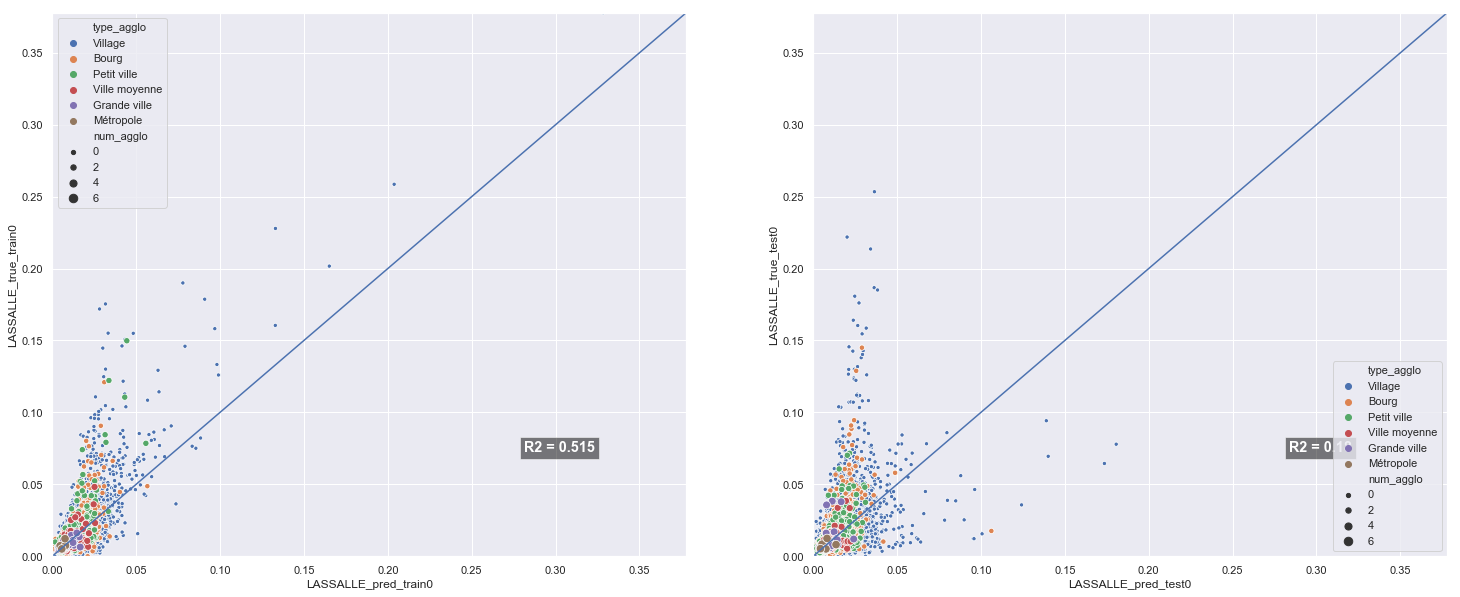

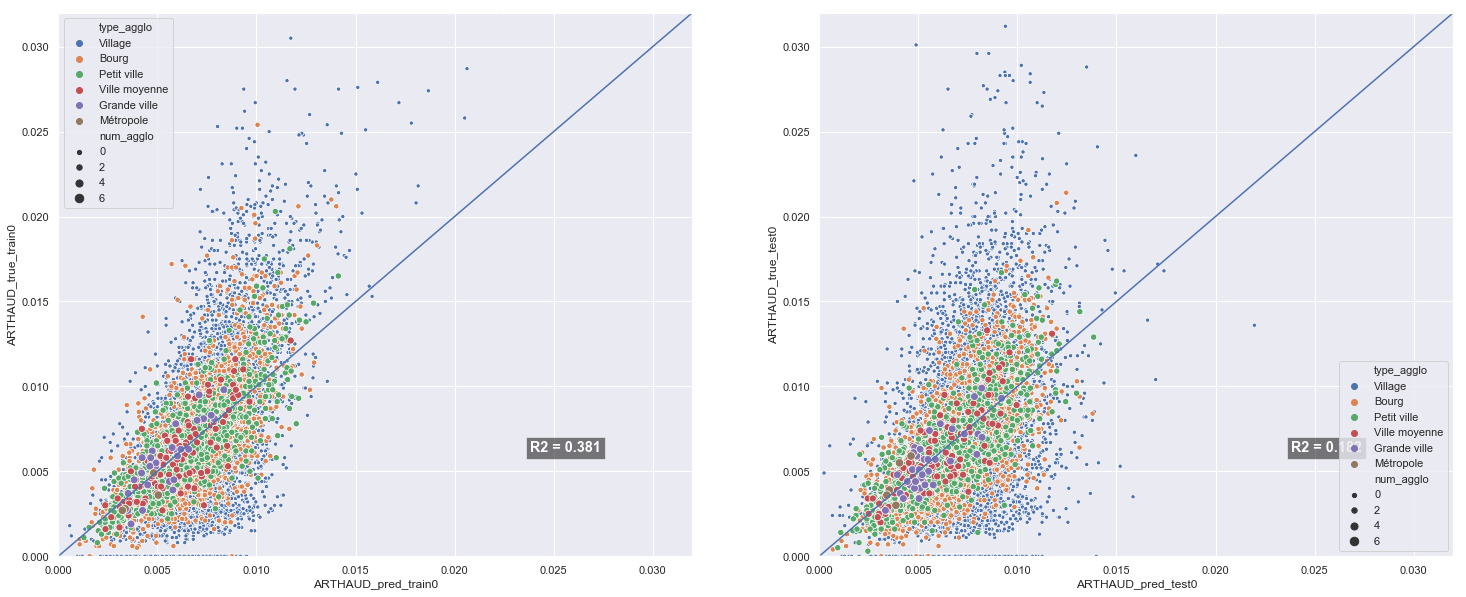

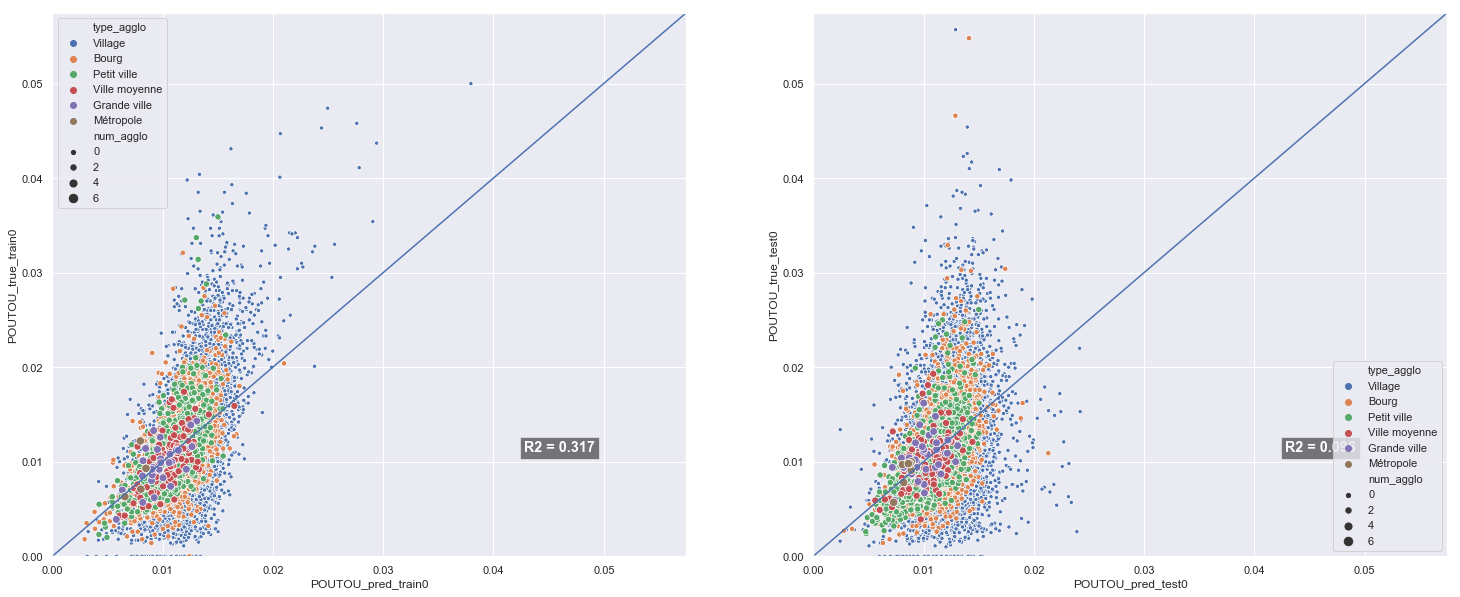

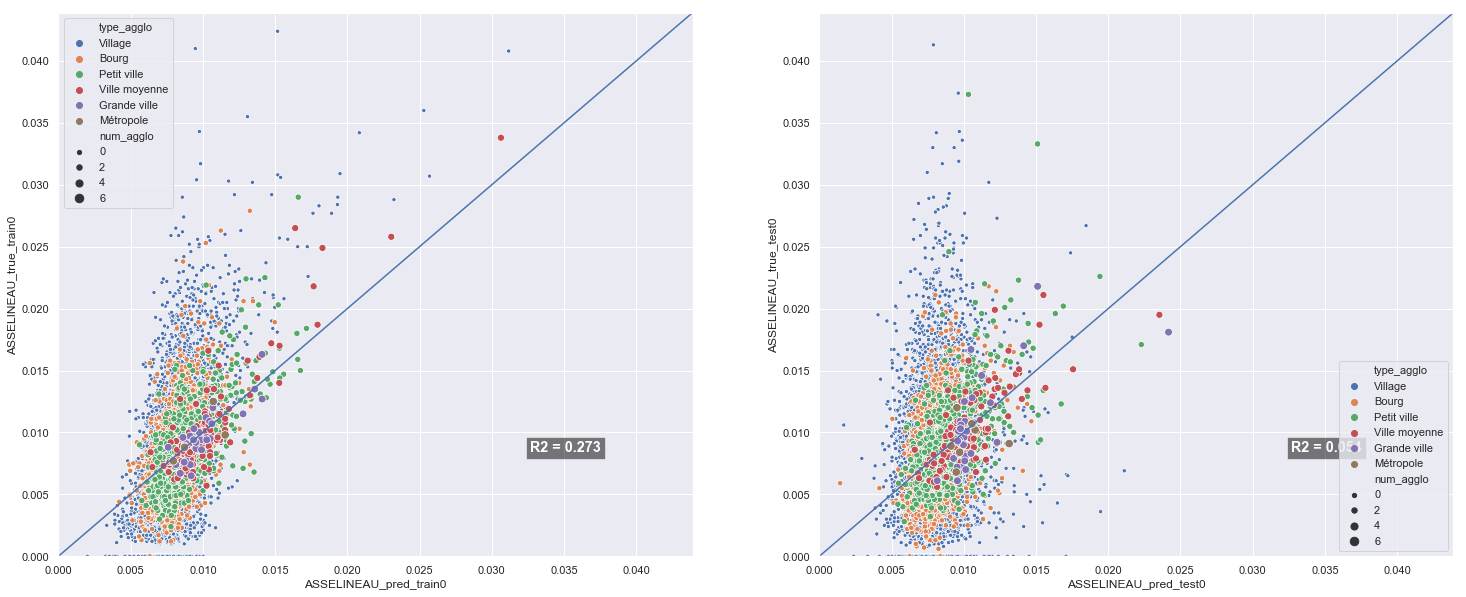

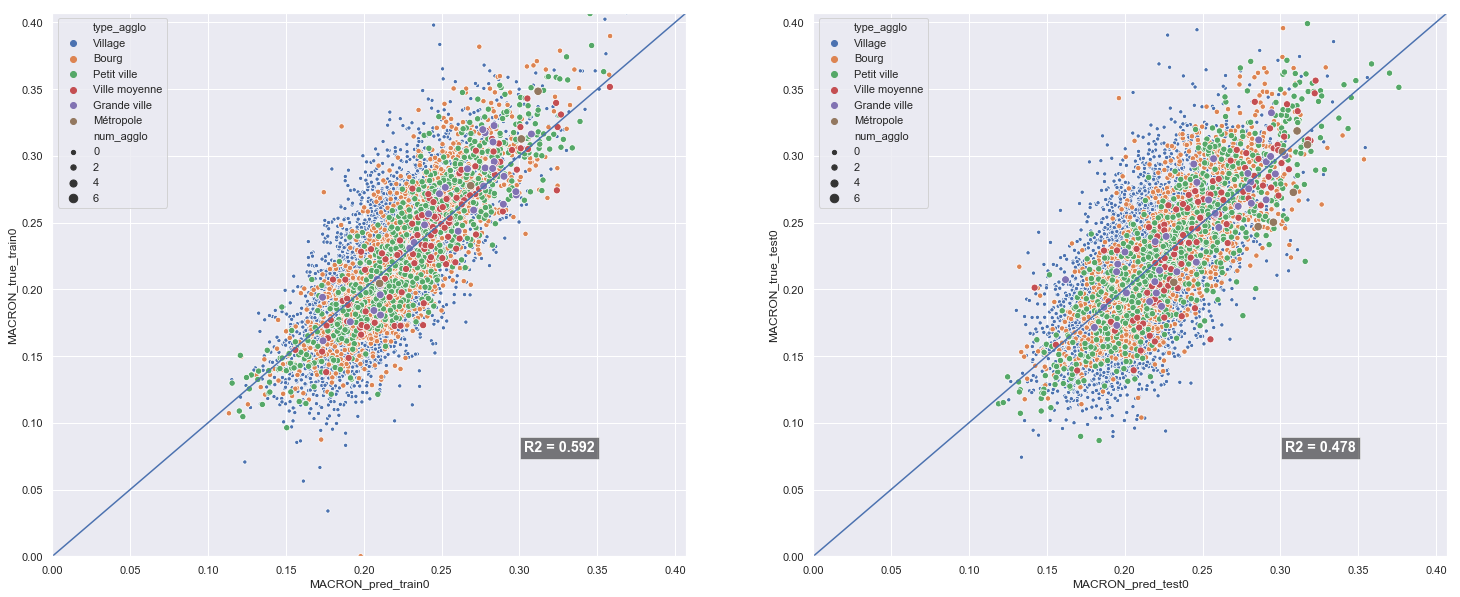

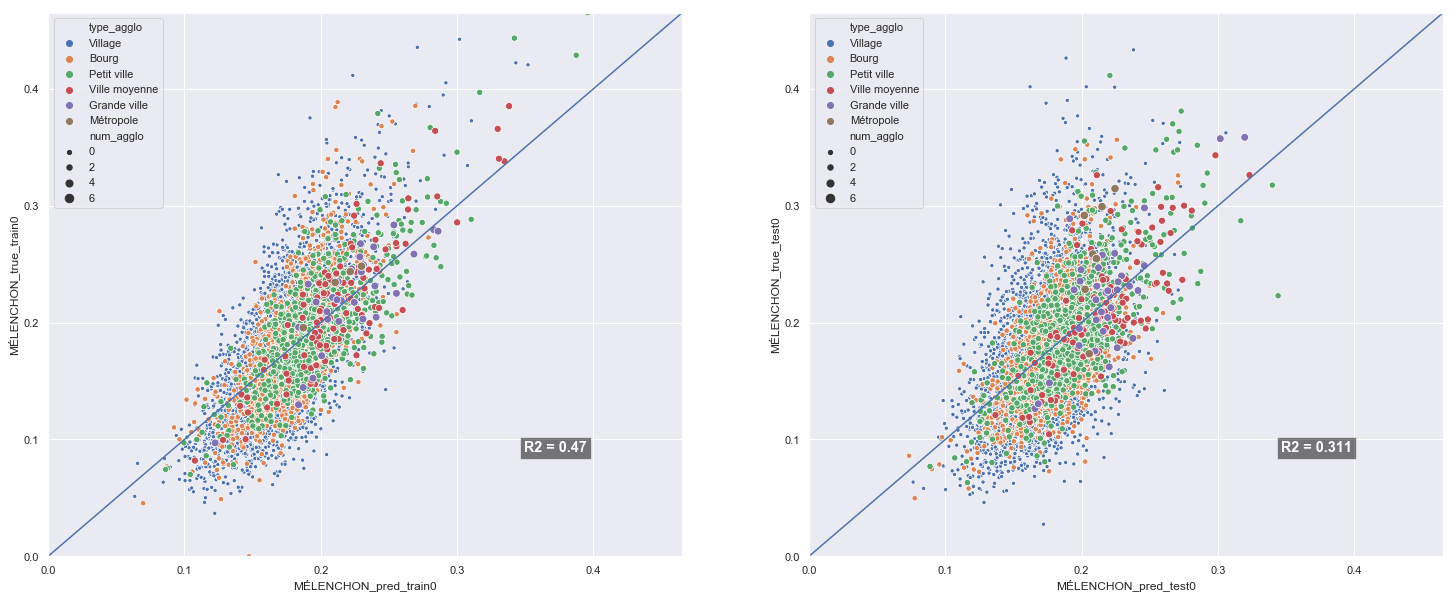

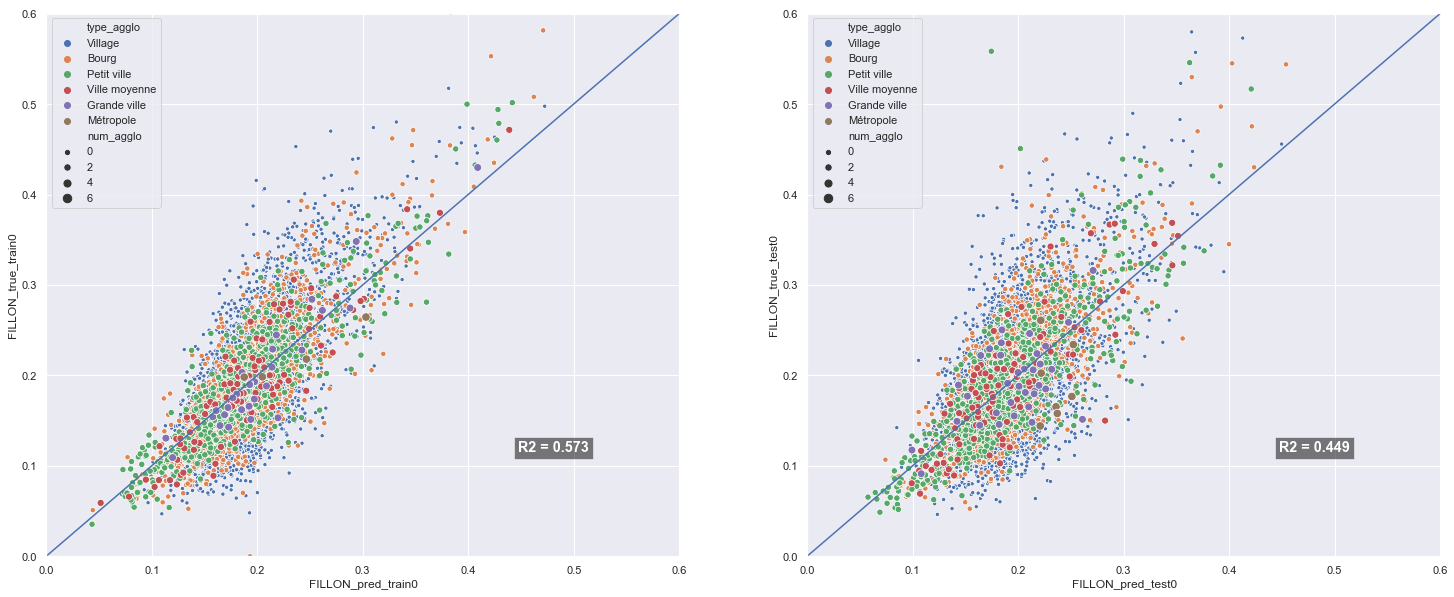

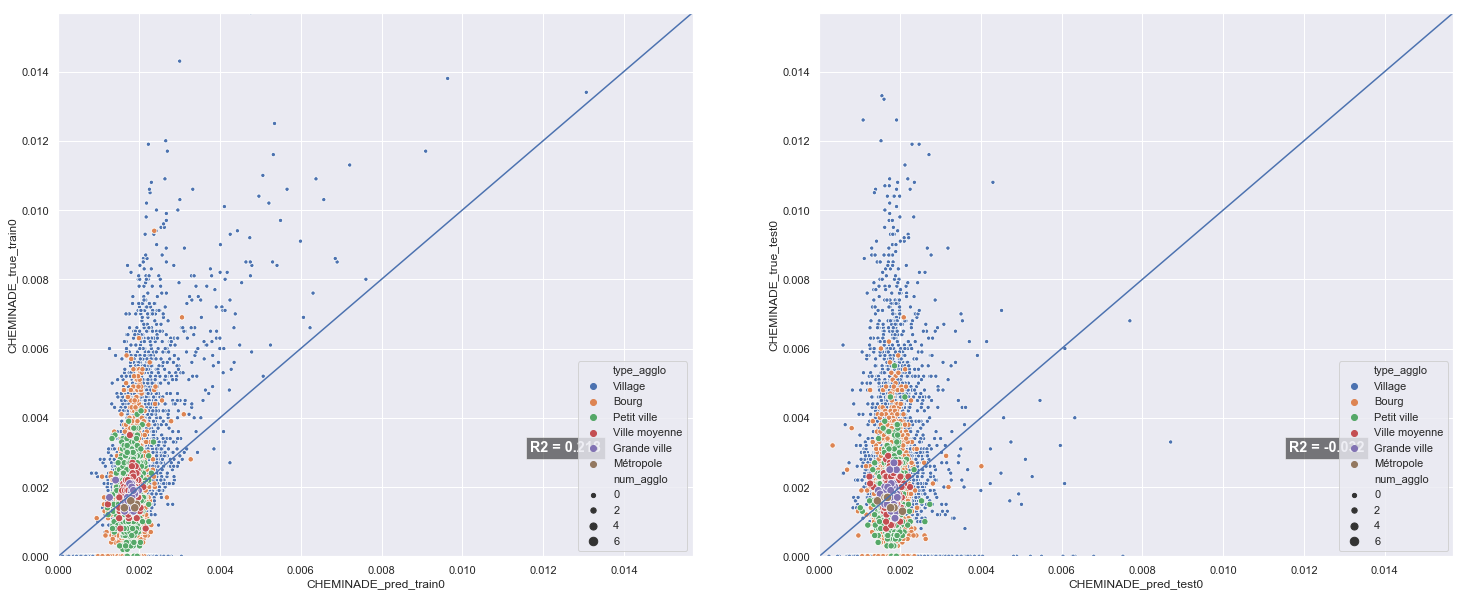

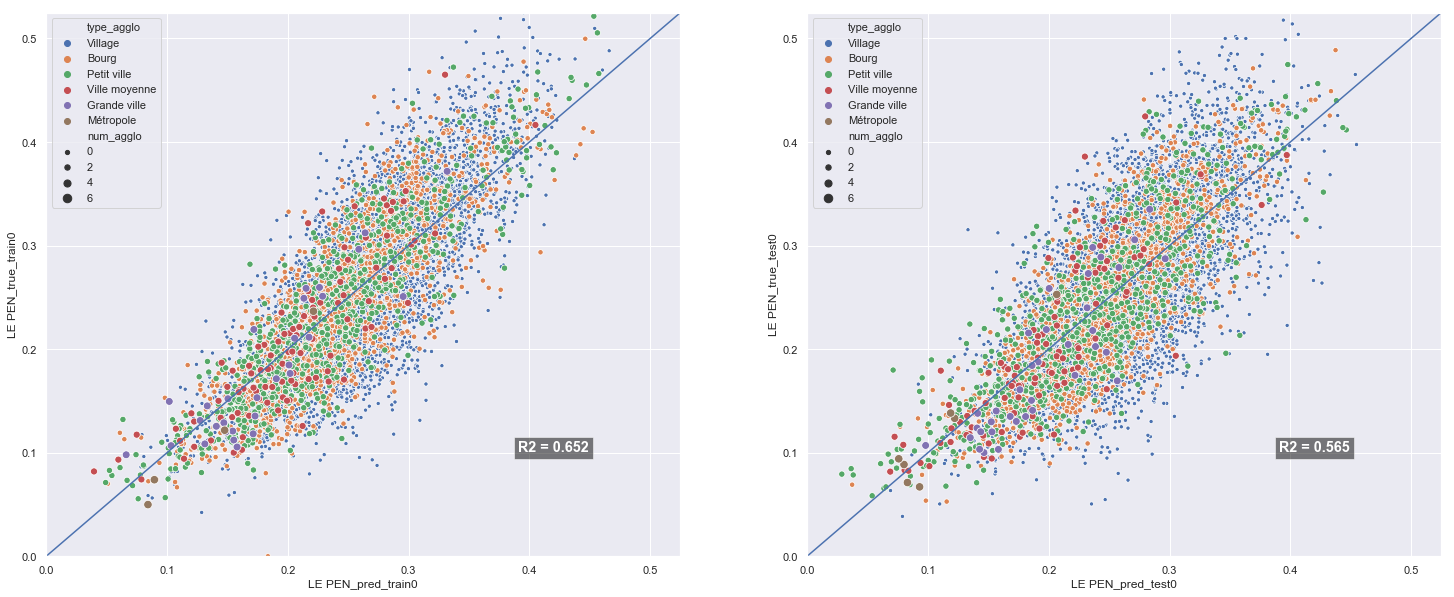

In [8]:
all_results = pd.DataFrame(columns=candidates_list)
y_test_df = pd.DataFrame(y_test, columns=candidates_list)

columns_importancy = pd.DataFrame(features_to_keep, columns=['column'])

for i in range(0,11):
    clf = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=2, random_state=0, loss='ls')
    y_train_candidate = y_train[:,i]
    y_test_candidate = y_test[:,i]
    clf.fit(x_train,y_train_candidate)
    print('Train score : ',clf.score(x_train,y_train_candidate))
    y_pred_train = pd.DataFrame(clf.predict(x_train),columns=[candidates_list[i]])
    y_pred_test = pd.DataFrame(clf.predict(x_test), columns=[candidates_list[i]])
    all_results[candidates_list[i]] = y_pred_test[candidates_list[i]]
    
    regression_plot(y_train, y_test, [(y_pred_train, y_pred_test)], 
                    candidates_list[i],
                    commune_index_train, 
                    commune_index_test,
                    save=True,
                    plot_name=candidates_list[i])
    
    #Get most important features
    #columns_importancy[candidates_list[i]] = clf.feature_importances_

In [33]:
print('Mean R2 score : ',np.mean(compute_R2_df(all_results, y_test_df,verbose=True)))

R2 for HAMON  :  0.2579221140418887
R2 for DUPONT-AIGNAN  :  0.2484983282504708
R2 for LASSALLE  :  0.17895163920865664
R2 for ARTHAUD  :  0.18440983699021052
R2 for POUTOU  :  0.10035384859754748
R2 for ASSELINEAU  :  0.05626884987424918
R2 for MACRON  :  0.47736056680768446
R2 for MÉLENCHON  :  0.30412600086693375
R2 for FILLON  :  0.4412800421182155
R2 for CHEMINADE  :  -0.026080252563891015
R2 for LE PEN  :  0.5618957209321696
Mean R2 score :  0.25318060864764874


In [ ]:
# FOR EACH CANDIDATES SELECT 5 MOST IMPORTANT FEATURES 
most_important_feature = pd.DataFrame(columns=candidates_list)
for i,cand in enumerate(candidates_list):
    columns_importancy['abs'] = columns_importancy[cand].apply(abs)
    columns_importancy = columns_importancy.sort_values('abs', ascending=False)
    most_important_feature[cand] = columns_importancy.iloc[:5,i+1].ravel()
    most_important_feature[cand+"_FNAME"] = columns_importancy.iloc[:5,0].ravel()
    
most_important_feature

In [ ]:
f, axes = plt.subplots(11, 1, figsize=(25, 55))
for i, cand in enumerate(candidates_list):
    sns.barplot(x=cand, y=cand+"_FNAME", data=most_important_feature, ax = axes[i])

# CANDIDATES EMBEDDING

### Idea : use the weight of the 11 trained log_reg to embedded the candidates 
 

In [30]:
# TRAIN 11 neurons in parallel (inside 11 different neural network models)
# Note that we do not output a probability distribution anymore. But we don't care because
# we just want to try to embed the candidats into vectors
list_of_logreg = [Log_reg_one_neuron(nb_features) for i in range(11)]
list_of_optims = [torch.optim.Adam(list_of_logreg[i].parameters()) for i in range(11)]
list_of_losses = [(lambda x : lambda y,target : cross_entropy_loss_1Neuron(y, target[:,x].view(-1,1)))(i)\
                   for i in range(11)]

In [38]:
train_neurals_networks(n_epochs=50, train_loader=train_loader, \
                       list_of_loss_function=list_of_losses, \
                       list_of_models=list_of_logreg,\
                       list_of_optim=list_of_optims,
                       print_epochs=10)

epoch n° 0
  model n° 0 - loss : 0.20815488136430302
  model n° 1 - loss : 0.21528171121794293
  model n° 2 - loss : 0.07566689934249216
  model n° 3 - loss : 0.041283038510403165
  model n° 4 - loss : 0.06319933087333267
  model n° 5 - loss : 0.045128639490111894
  model n° 6 - loss : 0.5187849682261686
  model n° 7 - loss : 0.4643688869308418
  model n° 8 - loss : 0.4828595180466701
  model n° 9 - loss : 0.01311019578065391
  model n° 10 - loss : 0.5629100382607868
----
epoch n° 10
  model n° 0 - loss : 0.208147020826877
  model n° 1 - loss : 0.21527649539177407
  model n° 2 - loss : 0.07566319832779432
  model n° 3 - loss : 0.04116005356043157
  model n° 4 - loss : 0.06320789598033462
  model n° 5 - loss : 0.04510664555108603
  model n° 6 - loss : 0.5187787462568059
  model n° 7 - loss : 0.46438311816940847
  model n° 8 - loss : 0.48289451352867163
  model n° 9 - loss : 0.011884190089685815
  model n° 10 - loss : 0.5628943695148951
----
epoch n° 20
  model n° 0 - loss : 0.2081685769

In [39]:
y_pred_train = pd.DataFrame(columns=candidates_list)
y_pred_test = pd.DataFrame(columns=candidates_list)

with torch.no_grad():
    for i, cand in enumerate(candidates_list):
        y_pred_train[cand] = list_of_logreg[i](torch.from_numpy(x_train).float()).view(-1).numpy()
        y_pred_test[cand] = list_of_logreg[i](torch.from_numpy(x_test).float()).view(-1).numpy()

In [40]:
y_pred_train.head()

HAMON  DUPONT-AIGNAN  LASSALLE   ARTHAUD    POUTOU  ASSELINEAU  \
0  0.059958       0.052195  0.008392  0.003467  0.007573    0.007385   
1  0.073382       0.032843  0.006997  0.003609  0.008863    0.009045   
2  0.052143       0.050218  0.013050  0.005246  0.009171    0.006897   
3  0.049510       0.058018  0.013397  0.006550  0.010440    0.009589   
4  0.064860       0.048038  0.023099  0.004294  0.011075    0.006608   

     MACRON  MÉLENCHON    FILLON  CHEMINADE    LE PEN  
0  0.278547   0.162168  0.234687   0.000681  0.181510  
1  0.260368   0.228436  0.189278   0.000713  0.168368  
2  0.237126   0.167828  0.215429   0.000970  0.223706  
3  0.211925   0.178746  0.161975   0.000723  0.286418  
4  0.248653   0.206186  0.169768   0.000847  0.210578

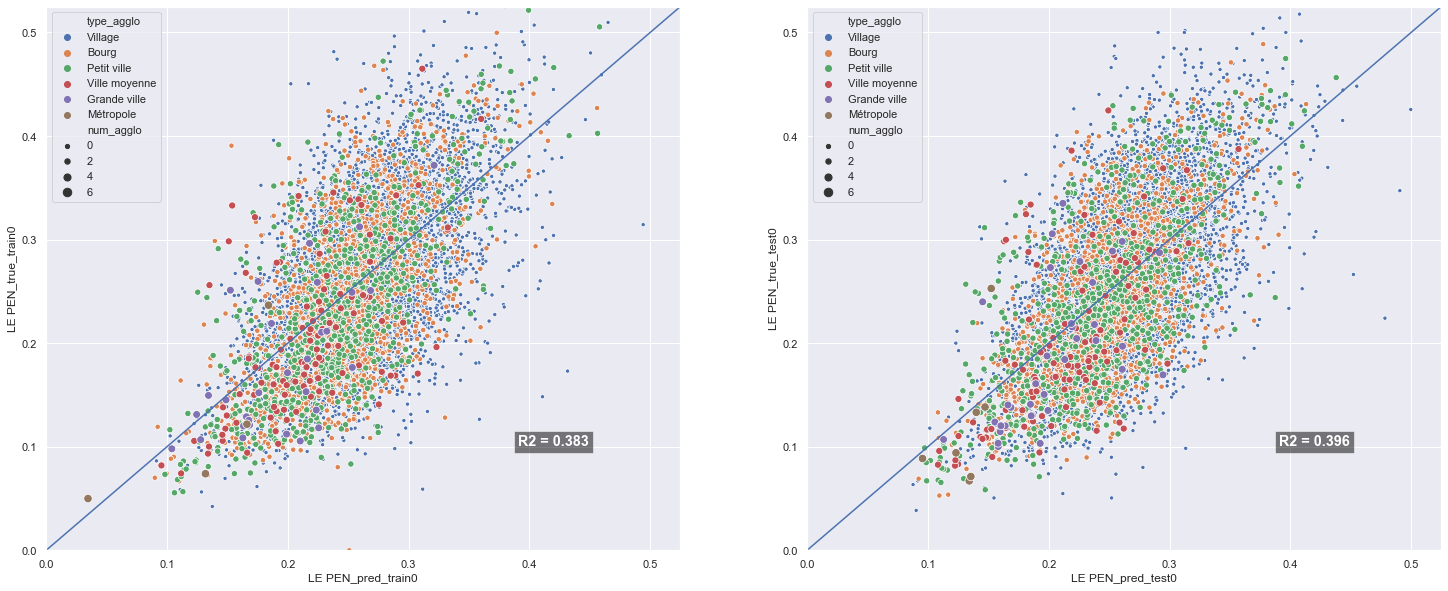

In [41]:
# QUICKLY CHECK IF WE HAVE LEARNED ANYTHING BEFORE PROCEDDING TO THE EMBEDDING
regression_plot(y_train, y_test, [(y_pred_train, y_pred_test)], "LE PEN", commune_index_train, commune_index_test)

In [42]:
# COLLECT THE WEIGHT OF EACH LOGISTIC REGRESSION 
candidates_features_weight = pd.DataFrame(columns= candidates_list)
for i, cand in enumerate(candidates_list):
    candidates_features_weight[cand] = (list(list_of_logreg[i].parameters()))[0].detach().numpy().reshape(-1)
    

In [43]:
# ONLY KEEP CANDIDATES WHICH HAS AT LEAST SUCCEED TO OBTAIN MORE THAN 2% OF THE VOTES 
big_candidates = ['HAMON', 'DUPONT-AIGNAN', 'MACRON', 'MÉLENCHON', 'FILLON', 'LE PEN']
candidates_features_weight = candidates_features_weight[big_candidates]


In [45]:
#NORMALIZE FEATURES 
scaler = StandardScaler()
scaler.fit(candidates_features_weight)

cand_fw_scale = pd.DataFrame(scaler.transform(candidates_features_weight), columns=big_candidates)

features = cand_fw_scale.T

In [47]:
# PROJECT CANDIDATES EMBEDDING INTO A 2D SPACE 
pca = PCA(n_components=2)
df_component = pd.DataFrame(pca.fit_transform(features), columns=["Comp1", "Comp2"])
df_component["Candidats"] = big_candidates

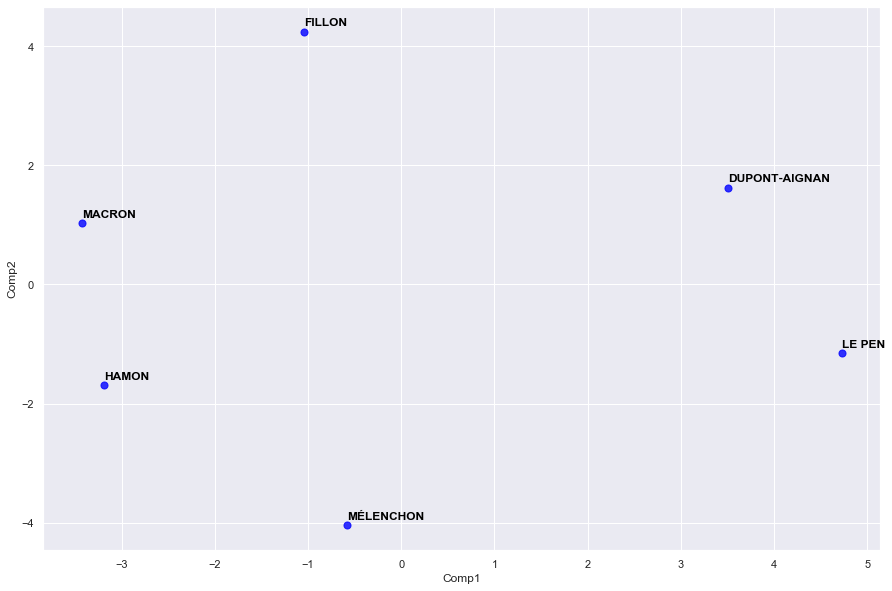

In [48]:
# PLOT 2D PROJECTION OF THE CANDIDATES
f, axes = plt.subplots(1, 1, figsize=(15, 10))
p1=sns.regplot(data=df_component, x="Comp1", y="Comp2", fit_reg=False,\
               marker="o", color="blue", scatter_kws={'s':50})
for line in range(0,df_component.shape[0]):
    p1.text(df_component.Comp1[line]+0, df_component.Comp2[line]+0.1, df_component.Candidats[line], \
             horizontalalignment='left', size='large', color='black', weight='semibold')

# FEATURES IMPORTANCIES ANALYSIS 

In [68]:
# FOR EACH CANDIDATES SELECT 5 MOST IMPORTANT FEATURES 
most_important_feature = pd.DataFrame(columns=candidates_list)
for i,cand in enumerate(candidates_list):
    candidates_features_weight['abs'] = candidates_features_weight[cand].apply(abs)
    candidates_features_weight = candidates_features_weight.sort_values('abs', ascending=False)
    most_important_feature[cand] = candidates_features_weight.iloc[:5,i+1].ravel()
    most_important_feature[cand+"_FNAME"] = candidates_features_weight.iloc[:5,0].ravel()


In [69]:
most_important_feature

HAMON  DUPONT-AIGNAN  LASSALLE   ARTHAUD    POUTOU  ASSELINEAU  \
0 -0.193450       0.088238 -0.259290  0.124016 -0.126626   -0.103392   
1 -0.137319       0.082406  0.236224  0.117588  0.102869   -0.081357   
2  0.107597       0.077365 -0.226491  0.115321 -0.091709   -0.076817   
3 -0.102616       0.077254 -0.179429  0.114426 -0.080821    0.073656   
4  0.100602       0.070305  0.156708  0.109373  0.078097   -0.064646   

     MACRON  MÉLENCHON    FILLON  CHEMINADE  ...  DUPONT-AIGNAN_FNAME  \
0  0.259732  -0.103275  0.154203   0.120783  ...        part_commerce   
1  0.223162  -0.103243  0.140161  -0.103646  ...           part_indus   
2 -0.154878  -0.103224  0.120109   0.085172  ...     fmly_no_child-25   
3 -0.118617   0.100720  0.117434   0.082273  ...           part_admin   
4 -0.114293  -0.087366  0.112689  -0.079986  ...     ratio_no_diploma   

      LASSALLE_FNAME     ARTHAUD_FNAME       POUTOU_FNAME  ASSELINEAU_FNAME  \
0              propr  ratio_no_diploma  mean_familiy_size            maison   
1            pop+65y        part_0_sal   part_non_salarié      part_salarié   
2                hlm        part-10sal               appt       nb_crea_ent   
3            pop-25y     ratio_CAP_BEP            pop+65y            nb_ent   
4  mean_familiy_size             propr             nb_ent  part_non_salarié   

        MACRON_FNAME    MÉLENCHON_FNAME FILLON_FNAME   CHEMINADE_FNAME  \
0              propr  mean_familiy_size   part-10sal        part_0_sal   
1          locataire   ratio_no_diploma   part_0_sal  fmly_no_child-25   
2   ratio_no_diploma    ratio_etude_sup      pop+65y        part-10sal   
3  mean_familiy_size            pop-15y    locataire            nb_ent   
4      ratio_CAP_BEP         res_second         appt       nb_crea_ent   

        LE PEN_FNAME  
0              propr  
1          locataire  
2   ratio_no_diploma  
3  mean_familiy_size  
4      ratio_CAP_BEP  

[5 rows x 22 columns]

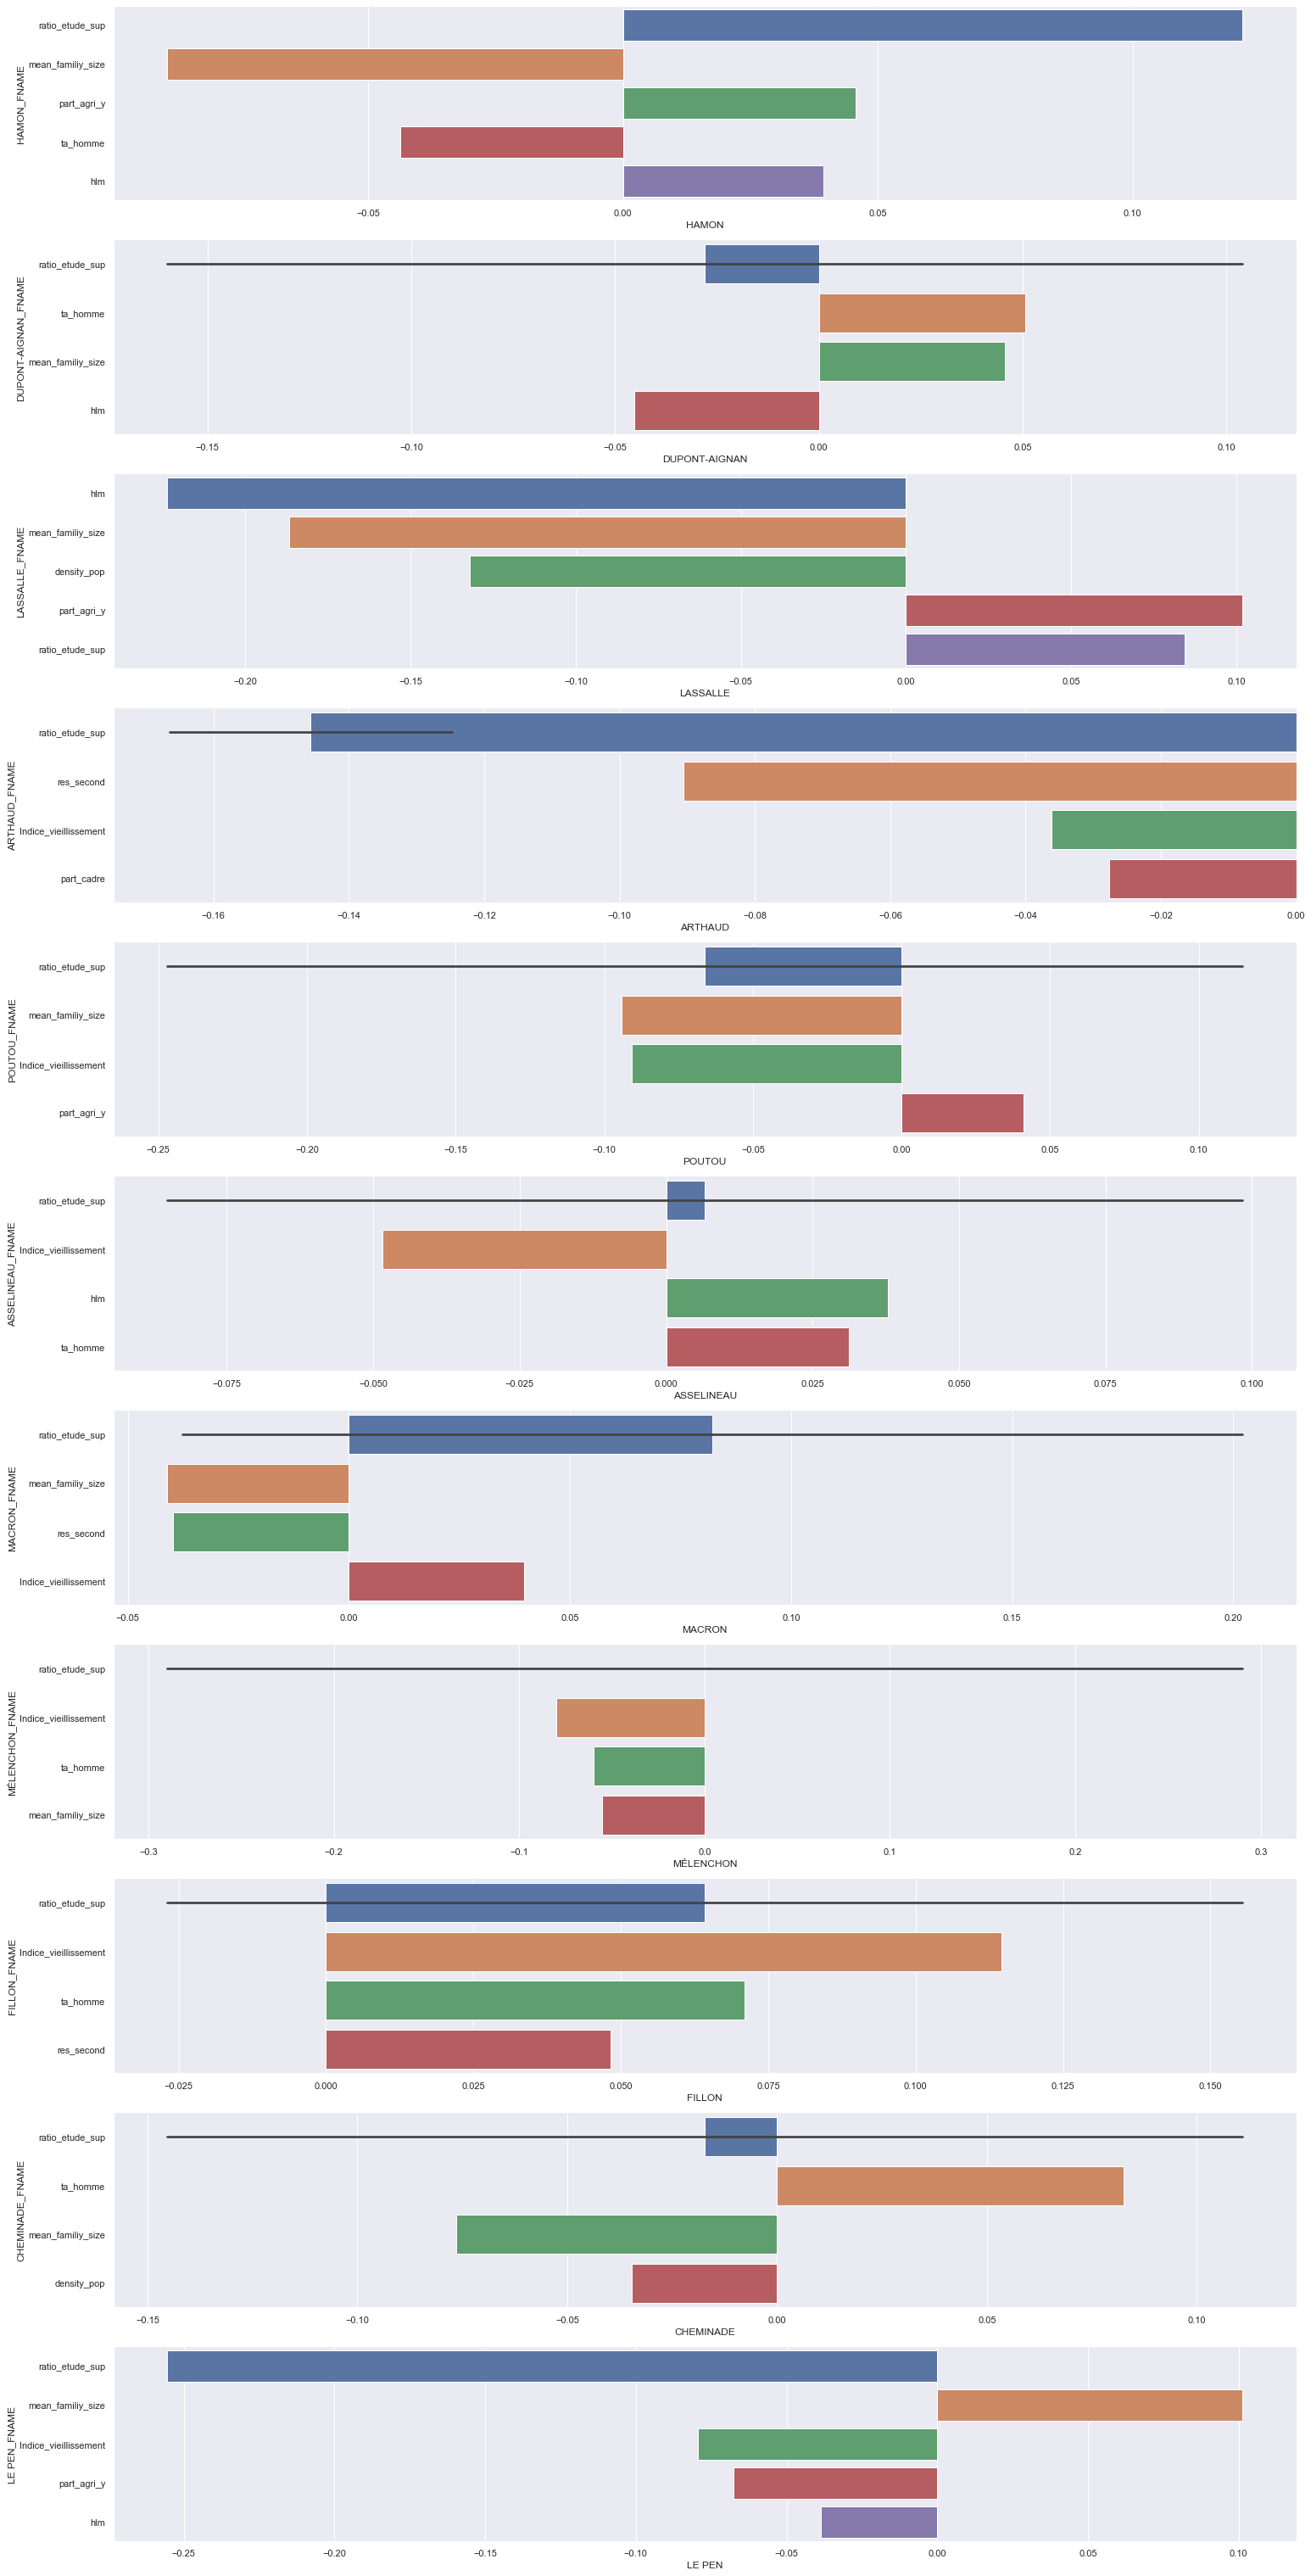

In [46]:
f, axes = plt.subplots(11, 1, figsize=(25, 55))
for i, cand in enumerate(candidates_list):
    sns.barplot(x=cand, y=cand+"_FNAME", data=most_important_feature, ax = axes[i])

In [9]:
l = [0,3,2,1]

In [12]:
sum(l)

6